In [2]:
!pip install prophet

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import joblib
warnings.filterwarnings("ignore")

# Data Preprocessing

In [2]:
# Load the dataset
data = pd.read_csv('MarketPricePrediction.csv')


In [3]:
# Data Preprocessing
data['date'] = pd.to_datetime(data['date'])
data.sort_values(by='date', inplace=True)
data.set_index('date', inplace=True)

In [4]:
# Handling missing values
data.fillna(method='ffill', inplace=True)



In [5]:
# Encoding categorical variables
le_market = LabelEncoder()
data['market'] = le_market.fit_transform(data['market'])
le_state = LabelEncoder()
data['state'] = le_state.fit_transform(data['state'])
le_city = LabelEncoder()
data['city'] = le_city.fit_transform(data['city'])

# Exploratory Data Analysis (EDA)

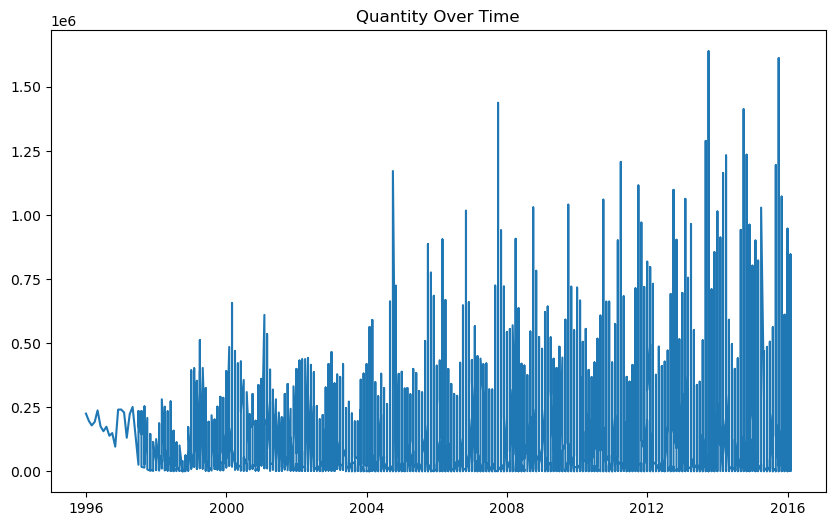

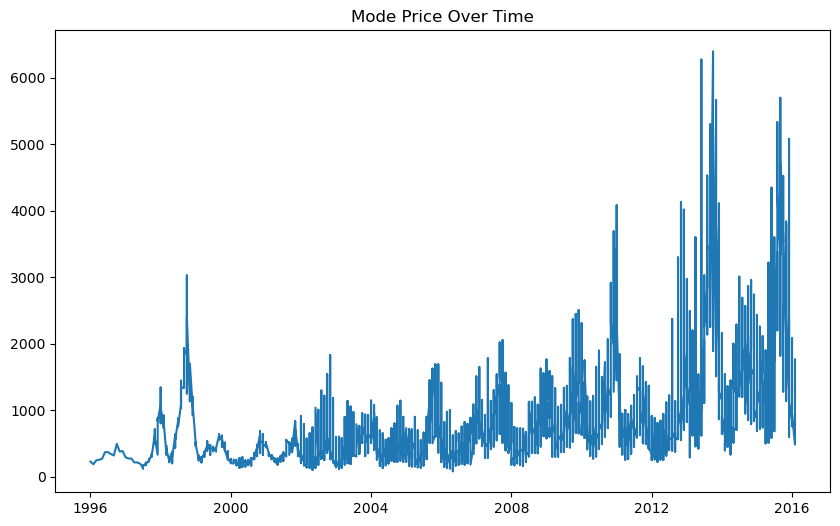

In [6]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10,6))
plt.plot(data['quantity'])
plt.title('Quantity Over Time')
plt.show()

plt.figure(figsize=(10,6))
plt.plot(data['priceMod'])
plt.title('Mode Price Over Time')
plt.show()

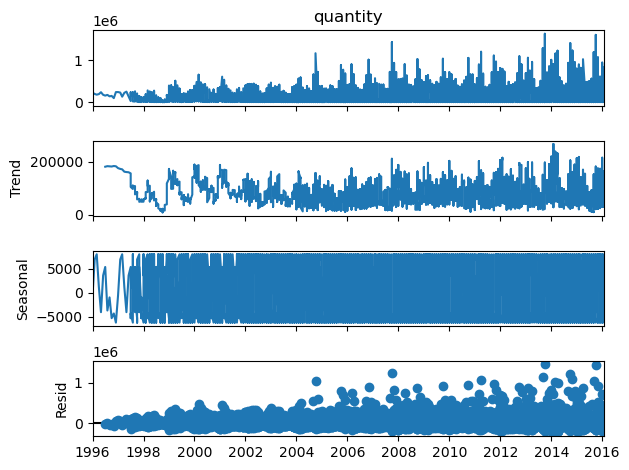

In [7]:
# Decomposing the time series
decomposition = seasonal_decompose(data['quantity'], model='additive', period=12)
fig = decomposition.plot()
plt.show()

# Feature Engineering

In [8]:
# Checking for stationarity
result = adfuller(data['quantity'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -17.986030761544722
p-value: 2.7644933737513937e-30


In [9]:
# Feature Engineering
data['month'] = data.index.month
data['year'] = data.index.year
data['lag_quantity_1'] = data['quantity'].shift(1)
data['rolling_mean_quantity'] = data['quantity'].rolling(window=3).mean()

In [10]:
# Splitting the data
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# ARIMA Model

In [11]:
# Model Selection and Training
arima_model = ARIMA(train_data['quantity'], order=(5,1,0))
arima_model_fit = arima_model.fit()
arima_pred = arima_model_fit.forecast(steps=len(test_data))
arima_mae = mean_absolute_error(test_data['quantity'], arima_pred)
arima_rmse = np.sqrt(mean_squared_error(test_data['quantity'], arima_pred))
print(f'ARIMA MAE: {arima_mae}, RMSE: {arima_rmse}')

ARIMA MAE: 112306.45827912417, RMSE: 152481.37835219255


# Prophet Model

In [12]:
prophet_df = train_data.reset_index()[['date', 'quantity']]
prophet_df.columns = ['ds', 'y']
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=len(test_data))
forecast = prophet_model.predict(future)
prophet_mae = mean_absolute_error(test_data['quantity'], forecast['yhat'][-len(test_data):])
prophet_rmse = np.sqrt(mean_squared_error(test_data['quantity'], forecast['yhat'][-len(test_data):]))
print(f'Prophet MAE: {prophet_mae}, RMSE: {prophet_rmse}')

23:10:29 - cmdstanpy - INFO - Chain [1] start processing
23:10:30 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 91560.48629712456, RMSE: 149524.1126286779


# LSTM Model

In [13]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

scaler = MinMaxScaler(feature_range=(0, 1))
lstm_data = scaler.fit_transform(data['quantity'].values.reshape(-1,1))
train_size = int(len(lstm_data) * 0.8)
train, test = lstm_data[0:train_size], lstm_data[train_size:len(lstm_data)]
time_step = 3
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, batch_size=1, epochs=1)

lstm_train_predict = lstm_model.predict(X_train)
lstm_test_predict = lstm_model.predict(X_test)

lstm_train_predict = scaler.inverse_transform(lstm_train_predict)
lstm_test_predict = scaler.inverse_transform(lstm_test_predict)
lstm_mae = mean_absolute_error(y_test, lstm_test_predict)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_test_predict))



8177/8177 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0051
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [14]:
print(f'LSTM MAE: {lstm_mae}, RMSE: {lstm_rmse}')

LSTM MAE: 81733.49029668307, RMSE: 81733.49126810308


# Model Evaluation

In [15]:
# Comparing all models
print(f'ARIMA MAE: {arima_mae}, RMSE: {arima_rmse}')
print(f'Prophet MAE: {prophet_mae}, RMSE: {prophet_rmse}')
print(f'LSTM MAE: {lstm_mae}, RMSE: {lstm_rmse}')


ARIMA MAE: 112306.45827912417, RMSE: 152481.37835219255
Prophet MAE: 91560.48629712456, RMSE: 149524.1126286779
LSTM MAE: 81733.49029668307, RMSE: 81733.49126810308


# Fine-tuning and Validation

In [16]:
joblib.dump(lstm_model, 'best_model.pkl')
# Fine-tuning and Validation
# Hyperparameter tuning can be done using GridSearchCV or similar approaches

# Deployment ready model
# The saved model can be loaded and used for future predictions
best_model = joblib.load('best_model.pkl')

# Example of making a new prediction
new_data = test_data['quantity'][-time_step:].values.reshape(-1, 1)
if new_data.shape[0] == time_step:
    new_data = scaler.transform(new_data).reshape(1, time_step, 1)
    new_prediction = best_model.predict(new_data)
    new_prediction = scaler.inverse_transform(new_prediction)
    print(f'New prediction: {new_prediction}')
else:
    print(f'Insufficient data points to make a prediction with time_step = {time_step}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
New prediction: [[81718.95]]
